# Data augmentation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#As-Function-to-MAP:-CPU" data-toc-modified-id="As-Function-to-MAP:-CPU-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>As Function to MAP: CPU</a></span></li><li><span><a href="#DAug-as-Model:-GPU" data-toc-modified-id="DAug-as-Model:-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DAug as Model: GPU</a></span></li><li><span><a href="#Data-Loader-check" data-toc-modified-id="Data-Loader-check-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Loader check</a></span></li></ul></div>

In [1]:
import os
import glob
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

mpl.rcParams['image.cmap'] = 'gray'

TEST_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'test_folder'+os.path.sep+'test'
test_img_files = glob.glob(TEST_img_PATH+os.path.sep+'*.png')

In [ ]:
def parse_image(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D float tensor
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, (128,128))

    #min_max_sacler_norm
    img = tf.math.divide(tf.math.subtract(img, tf.math.reduce_min(img)),
                         tf.math.subtract(tf.math.reduce_max(img), tf.math.reduce_min(img)))
    #std_norm
    #img = tf.math.divide(tf.math.subtract(img, tf.math.reduce_mean(img)),tf.math.reduce_std(img))
    return img, tf.identity(img)

## As Function to MAP: CPU
* Advantage: Easy to customize
* Downside: Runs on CPU

```python
# Random crop and distorsioned
box = np.array([.3, .3, .8, .8])
boxes = box.reshape([1, 1, 4])
begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=boxes)
image = tf.slice(image, begin, size)
```


In [ ]:
def augment(image, label):    
    
    #Noise and Dropout
    rnds_noise = tf.random.uniform((1,2),minval=0, maxval=0.04)
    image = tf.nn.dropout(image,rnds_noise[0][0])
    image = tf.keras.layers.GaussianNoise(rnds_noise[0][1])(image, training=True)
    
    #Blankout and blur
    rnds_absolutes = tf.random.uniform((1,2),minval=0, maxval=1)
    if rnds_absolutes[0][0] < 0.2:
        size = tf.random.uniform((), minval=10, maxval=30, dtype=tf.dtypes.int32)
        offset = tf.random.uniform((), minval=10, maxval=100, dtype=tf.dtypes.int32)
        image = tfa.image.cutout(tf.expand_dims(image,0),  
                                 mask_size = (size,size ),
                                 offset = (offset, offset),
                                 constant_values = 0
                                )[0,...]
    if rnds_absolutes[0][1] < 0.1:
        image = tfa.image.gaussian_filter2d(image,
                                            filter_shape = [3, 3],
                                            sigma = 0.6,
                                            constant_values = 0,
                                           )
    #ZOOM - CROP
    #if rnds_crops[0][1] < 0.1:
        #image = tf.image.central_crop(image, central_fraction=0.7)
        #image = tf.image.resize(image, (128,128))
        
    # Normalization
    image = tf.math.divide(tf.math.subtract(image, tf.math.reduce_min(image)),
                                 tf.math.subtract(tf.math.reduce_max(image), tf.math.reduce_min(image)))
    return image, label
    


In [ ]:
prueba_aug_test = ['..\\IXI-T1\\PNG\\test_folder\\test\\IXI158-Guys-0783-T1_77.png']
prueba_aug_test.extend(random.sample(test_img_files,7))

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(prueba_aug_test)
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds = ds.map(parse_image, num_parallel_calls=AUTOTUNE)
ds = ds.repeat()
#shuffle
#Different augmentation for each image in batch
ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

ds = ds.batch(8)
#SAME AGUMENTATIN FOR ALL BATCH IMAGES IF IT IS DONE AFTER BATCH
#ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

ds = ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:

batchx, batchy = next(iter(ds))
print(batchx.shape, batchy.shape)
for x,y in zip(batchx, batchy):
    plt.figure(figsize=(12,9))
    plt.subplot(1,2,1)
    plt.imshow(x)
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title('Target')
    plt.show()

## DAug as Model: GPU
* Less powerfull to customize in a easy way

In [ ]:
y.shape

In [ ]:
data_aug_ly = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomCrop(102,102),
    #tf.keras.layers.experimental.preprocessing.RandomZoom(.5, .2)
    tf.keras.layers.experimental.preprocessing.Resizing(128,128)
])

In [ ]:
batchx, batchy = next(iter(ds))
for _,y in zip(batchx, batchy):
    plt.figure(figsize=(12,9))
    plt.subplot(1,2,1)
    plt.imshow(data_aug_ly(tf.expand_dims(y,axis=0))[0])
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title('Target')
    plt.show()

In [ ]:
tf.keras.layers.experimental.preprocessing.

```python
my model = tf.keras.layers.Sequential([
    Input,
    data_aug,
    conv,
    maxpool,
    ...,
]
)
```

## Data Loader check

In [2]:
from my_tf_data_loader_optimized import tf_data_png_loader

In [3]:
params = {'batch_size': 4,
          'cache':False,
          'shuffle_buffer_size':1000,
          'resize':(128,128),
          'train': True,
          'augment': True
         }
#train         
loader = tf_data_png_loader(test_img_files, **params)
l_ds = loader.get_tf_ds_generator()

(4, 128, 128, 1) (4, 128, 128, 1)


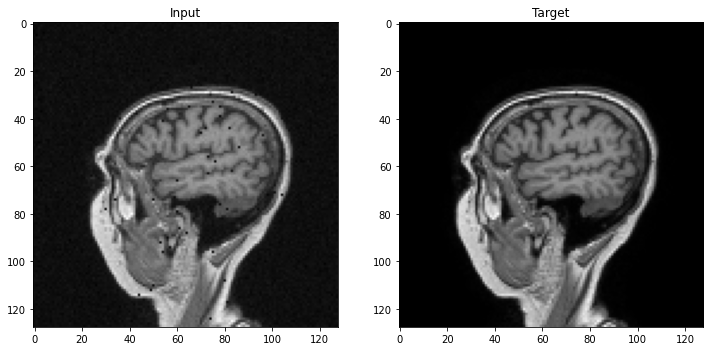

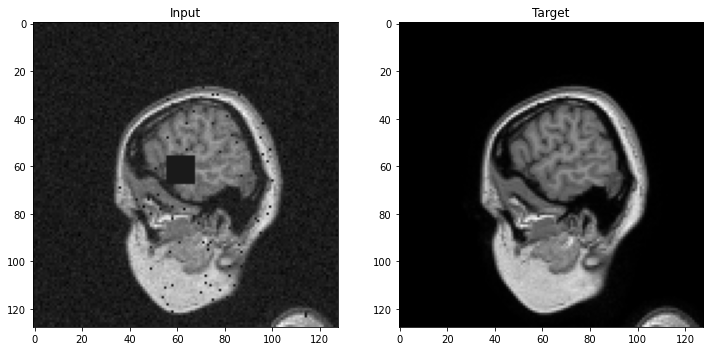

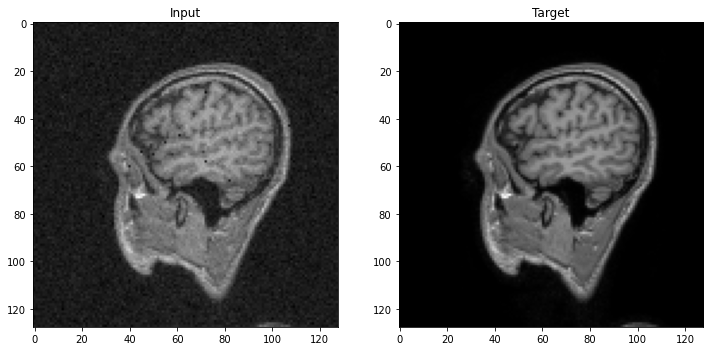

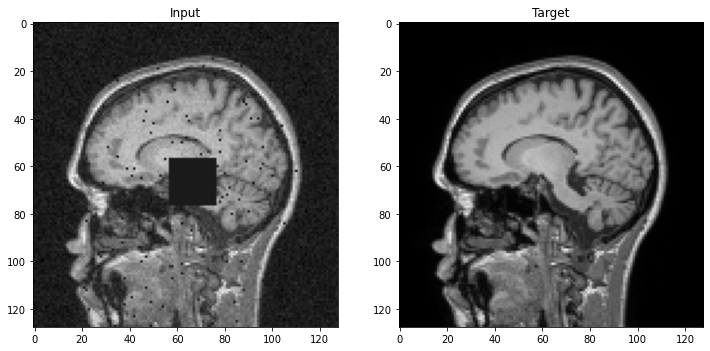

In [5]:
batchx, batchy = next(iter(l_ds))
print(batchx.shape, batchy.shape)
for x,y in zip(batchx, batchy):
    plt.figure(figsize=(12,9))
    plt.subplot(1,2,1)
    plt.imshow(x)
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title('Target')
    plt.show()

In [ ]:
train_loader